In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from utils import *
from models.scorenetwork import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate

from IPython.display import HTML
from IPython.display import clear_output

In [2]:
# initialize random seed
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
torch.set_default_tensor_type(FloatTensor)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
total_iteration = 1000
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.5
batch_size = 1000
dataloader = torch.utils.data.DataLoader(Cluster2DataSet(dist1, dist2, probability=probability, total_len=batch_size * total_iteration), batch_size = batch_size, drop_last = True)
dataiterator = iter(dataloader)

## Real Samples

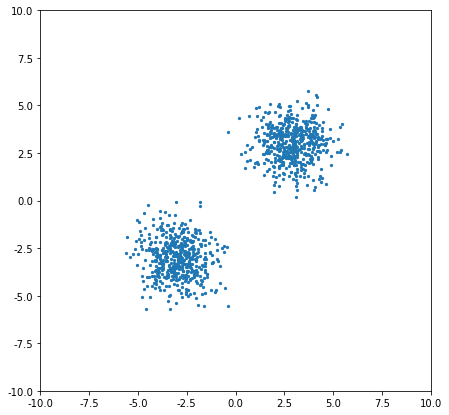

In [4]:
scatter(next(iter(dataloader)), True)

In [5]:
scatter_range = [-10, 10]
total_iteration = 2000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
# score network parameters
eps = 1e-6
sigma_min = 0.001
sigma_max = 10
n_steps = 10
annealed_step = 100

In [6]:
learning_rate = 5e-3
z_dim = 2
sample_dir = './results/clusters2_DAE'
lamd = 5000

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## Traning DAE

In [7]:
vae = VAE(input_size=2, h_dim=256, z_dim=2).to(device)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

sn = SN_Model(device, n_steps, sigma_min, sigma_max, p = 0.3)
sn_optim = torch.optim.Adam(sn.parameters(), lr = 0.005)
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps)

torch.multiprocessing.set_start_method('spawn', force=True)
# Start training
for i in range(total_iteration):
    try:
        data = dataiterator.next()
    except:
        dataiterator = iter(dataloader)
        data = dataiterator.next()
    data = data.to(device = device)
    #============= First Stage: Update VAE ==============#
    x_reconst, mu, log_var = vae(data)

    # Compute reconstruction loss and kl divergence
    reconst_loss = F.mse_loss(x_reconst, data)
    kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # Backprop and optimize
    loss_vae = lamd*reconst_loss + kl_div
    vae_optimizer.zero_grad()
    loss_vae.backward()
    vae_optimizer.step()

    #============= Second Stage: Update SN ==============#
    mu, log_var = vae.encode(data)
    z = vae.reparameterize(mu, log_var)

    loss_sn = sn.loss_fn(z)
    vae_optimizer.zero_grad()
    sn_optim.zero_grad()
    loss_sn.backward()
    sn_optim.step()

    if (i+1) % 100 == 0:
        print("Iteration[{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Diffuse loss: {:.4f}"
                .format(i+1, total_iteration, reconst_loss.item(), kl_div.item(), loss_sn.item()))

        with torch.no_grad():
            # save the reconst images (rebuild the input)
            out, _, _ = vae(data)
            scatter(out, only_final, scatter_range = scatter_range)
            plt.savefig(os.path.join(sample_dir, 'reconst-{}.png'.format(i+1)))
            # Save the sampled images (decode the noise)
            z = torch.randn(batch_size, z_dim).to(device)
            out = vae.decode(z)
            scatter(out, only_final, scatter_range = scatter_range)
            plt.savefig(os.path.join(sample_dir, 'sampled-{}.png'.format(i+1)))
            # Save the diffused images
            dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps)
            sample = dynamic.sampling(sampling_number, only_final)
            out = vae.decode(sample)
            scatter(out, only_final, scatter_range = scatter_range)
            plt.savefig(os.path.join(sample_dir, 'diffused-{}.png'.format(i+1)))
            plt.close('all')

Iteration[100/2000], Reconst Loss: 0.2174, KL Div: 2996.2068, Diffuse loss: 0.8336
Iteration[200/2000], Reconst Loss: 0.1981, KL Div: 3024.8589, Diffuse loss: 0.7328
Iteration[300/2000], Reconst Loss: 0.2327, KL Div: 2830.4199, Diffuse loss: 0.7232
Iteration[400/2000], Reconst Loss: 0.2082, KL Div: 2907.4131, Diffuse loss: 0.7319
Iteration[500/2000], Reconst Loss: 0.1974, KL Div: 2881.6562, Diffuse loss: 0.7039
Iteration[600/2000], Reconst Loss: 0.1861, KL Div: 2894.9409, Diffuse loss: 0.7140
Iteration[700/2000], Reconst Loss: 0.2060, KL Div: 2745.9436, Diffuse loss: 0.6714
Iteration[800/2000], Reconst Loss: 0.2125, KL Div: 2746.1484, Diffuse loss: 0.6780
Iteration[900/2000], Reconst Loss: 0.1940, KL Div: 2665.4958, Diffuse loss: 0.7193
Iteration[1000/2000], Reconst Loss: 0.2332, KL Div: 2473.2476, Diffuse loss: 0.7027
Iteration[1100/2000], Reconst Loss: 0.2071, KL Div: 2587.9072, Diffuse loss: 0.6773
Iteration[1200/2000], Reconst Loss: 0.2203, KL Div: 2522.4312, Diffuse loss: 0.7539
I

## Plot the hidden representation z

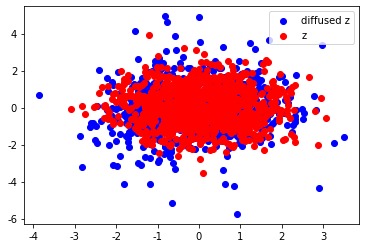

In [8]:
plt.scatter(sample[:,0].cpu().numpy(), sample[:,1].cpu().numpy(), c='b', label='diffused z')
plt.scatter(z[:,0].cpu().numpy(), z[:,1].cpu().numpy(), c='r', label='z')
plt.legend()

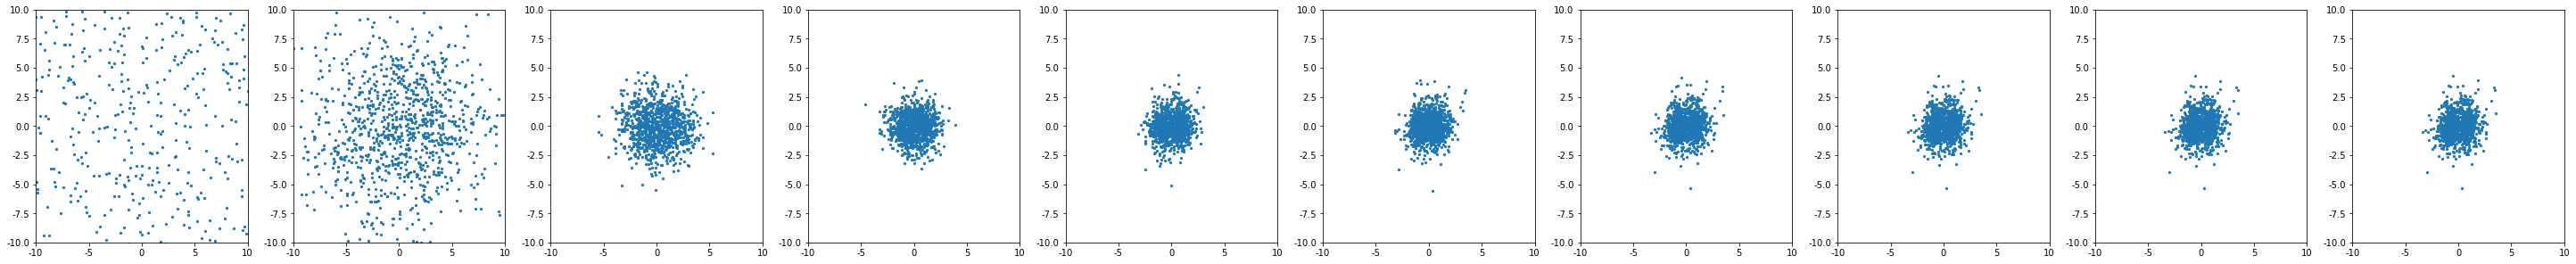

In [9]:
# Diffusion process of the latent variable z
sampling_number = 1000
only_final = False
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, sn, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
diffuse_data = vae.decode(sample)
scatter(sample, only_final)

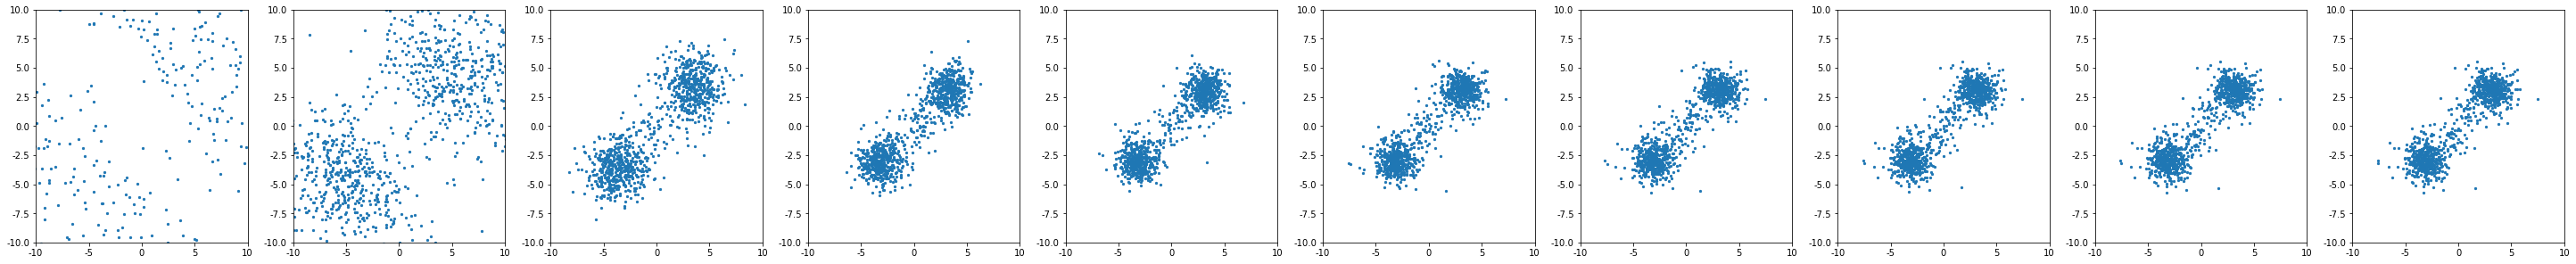

In [10]:
# The samples generated from Diffusion process of the latent variable z
scatter(diffuse_data, only_final, scatter_range = scatter_range)